
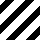
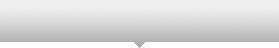
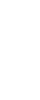
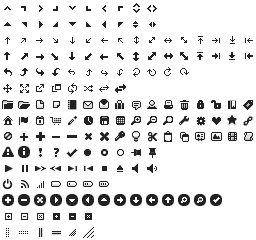
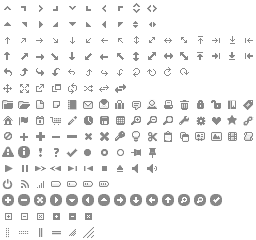
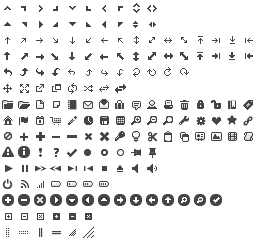
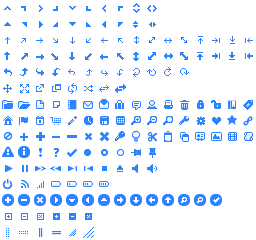
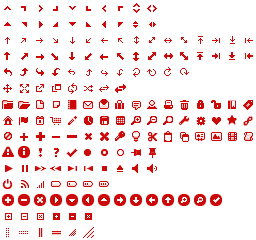
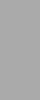
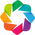
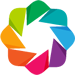
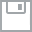
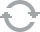
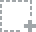
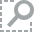
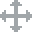
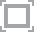
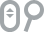

In [1]:
import pandas as pd
import numpy as np
import datetime
from bokeh.io import show, output_notebook
output_notebook()

In [2]:
raw = pd.read_table('timelog.txt', quotechar=' ', sep=': ', names=['timestamp', 'activity'], engine='python')

# Set the column types
raw.activity = raw.activity.astype('category')
raw.timestamp = pd.to_datetime(raw.timestamp)
raw.head()

,timestamp,activity
0,2015-06-28 06:42:00,start
1,2015-06-28 10:25:00,unicorns
2,2015-06-28 12:10:00,ponies
3,2015-06-28 14:18:00,unicorns
4,2015-06-28 16:28:00,ponies


Break it into seperate dfs for seperate days

In [3]:
activities = raw.activity.cat.categories
len(activities)

6

In [4]:
activities_df = pd.DataFrame(activities, columns=['activity']).reset_index()

frames = []
for _date in raw.timestamp.dt.date.unique():
    day_frame = raw[raw.timestamp.dt.date == _date]
    
    ## Now add on a start stamp for each of the activities
    start_stamp = day_frame[day_frame.activity == 'start'].timestamp.iloc[0]
    times = pd.DataFrame([start_stamp for i in range(len(activities))], columns=['timestamp']).reset_index()
    start_stamps_df = activities_df.merge(times).set_index('index')
    
    with_start = day_frame.append(start_stamps_df, ignore_index=True)
    with_start.sort('timestamp', inplace=True)
    with_start = with_start.reset_index(drop=True)
    
    ### Now build the time deltas
    with_start['end'] = with_start.timestamp
    with_start['start'] = with_start['end'].shift(1)
    with_start['delta'] = with_start.end - with_start.start
    
    frames.append(with_start)
    
frames[1].head(10)

,activity,timestamp,end,start,delta
0,start,2015-06-29 11:22:00,2015-06-29 11:22:00,NaT,NaT
1,serious business,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
2,ponies,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
3,oh the grind,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
4,flying,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
5,start,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
6,unicorns,2015-06-29 11:22:00,2015-06-29 11:22:00,2015-06-29 11:22:00,00:00:00
7,oh the grind,2015-06-29 12:12:00,2015-06-29 12:12:00,2015-06-29 11:22:00,00:50:00
8,unicorns,2015-06-29 12:36:00,2015-06-29 12:36:00,2015-06-29 12:12:00,00:24:00
9,serious business,2015-06-29 13:07:00,2015-06-29 13:07:00,2015-06-29 12:36:00,00:31:00


In [5]:
# Now we can drop the 'start' row
for frame in frames:
    frame.dropna(inplace=True)
frames[2].head(10)

,activity,timestamp,end,start,delta
1,serious business,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
2,ponies,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
3,oh the grind,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
4,flying,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
5,start,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
6,unicorns,2015-06-30 00:00:00,2015-06-30 00:00:00,2015-06-30 00:00:00,00:00:00
7,ponies,2015-06-30 01:46:00,2015-06-30 01:46:00,2015-06-30 00:00:00,01:46:00
8,ponies,2015-06-30 02:05:00,2015-06-30 02:05:00,2015-06-30 01:46:00,00:19:00
9,unicorns,2015-06-30 09:30:00,2015-06-30 09:30:00,2015-06-30 02:05:00,07:25:00
10,ponies,2015-06-30 10:49:00,2015-06-30 10:49:00,2015-06-30 09:30:00,01:19:00


In [6]:
split_frames = []
for frame in frames:
    frame_dict = {}
    for activity in activities:
        df = frame[frame['activity'] == activity]
        sumseries = df['delta'].cumsum()
        sumseries.name = 'cumsum'
        sumdf = pd.DataFrame(sumseries).reset_index()
        with_sum_df = df.reset_index().merge(sumdf, how='right', on='index')
        with_sum_df.drop('index', 1, inplace=True)
        with_sum_df['cumsum_hrs'] = with_sum_df['cumsum'].dt.seconds / (60 * 60)
        frame_dict[activity] = with_sum_df
    split_frames.append(frame_dict)
    
## Try smooth with interpolate
split_frames_smooth = []
for frame in frames:
    frame_dict = {}
    for activity in activities:
        df = frame[frame['activity'] == activity]
        sumseries = df['delta'].cumsum()
        sumseries.name = 'cumsum'
        sumdf = pd.DataFrame(sumseries).reset_index()
        with_sum_df = df.reset_index().merge(sumdf, how='right', on='index')
        with_sum_df.drop('index', 1, inplace=True)
        with_sum_df['cumsum_hrs'] = with_sum_df['cumsum'].dt.seconds / (60 * 60)
        sum_only = with_sum_df[['timestamp', 'cumsum_hrs']]
        sum_only = sum_only.set_index('timestamp')
        sum_only = sum_only.asfreq('1min')
        try:
            sum_only = sum_only.interpolate('pchip')
        except IndexError:
            pass
        frame_dict[activity] = sum_only.reset_index('timestamp')
    split_frames_smooth.append(frame_dict)

In [7]:
from bokeh.models import (
    Plot, Line, ColumnDataSource, 
    LinearAxis, DatetimeAxis, DataRange1d, 
    BasicTicker
)
from bokeh.palettes import Spectral6

def make_plot(split_frames):
    plot = Plot(
        x_range=DataRange1d(), 
        y_range=DataRange1d(), 
        background_fill='black', 
        border_fill='black',
        toolbar_location=None,
        outline_line_color=None,
        plot_width=900,
        plot_height=300
    )
    ticker = BasicTicker(min_interval=1)
    axis_properties = dict(
        major_label_text_color='white',
        ticker=ticker,
    )
    plot.add_layout(LinearAxis(**axis_properties), 'left')
    plot.add_layout(DatetimeAxis(**axis_properties), 'below')
    line_properties = dict(
        line_width=2,
        x='timestamp', 
        y='cumsum_hrs', 
    )

    for activity_frame in split_frames:
        for i, activity in enumerate(activities):
            frame = activity_frame[activity][['cumsum_hrs', 'timestamp']]
            source = ColumnDataSource(frame)
            plot.add_glyph(source, Line(line_color=Spectral6[i], line_join='round', line_cap='round', **line_properties))
            
    return plot

In [8]:
show(make_plot(split_frames))

In [9]:
show(make_plot(split_frames_smooth))